# PokéGAN 2

### Import libraries 

In [2]:
import torch
from torch.autograd import Variable,grad
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from PIL import Image,ImageFile
import glob
from torchvision.transforms import Compose,ToTensor,ToPILImage,Resize,Normalize,CenterCrop
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import pandas as pd
import os
import cv2
from torch.utils.data import Dataset
import albumentations
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

### Global variable 

In [3]:
use_GPU = torch.cuda.is_available()

batch_size = 64
image_size = [3,128,128]
padding = 2
stride = 2
kernel_size = 5
latent_dim = 128 #dimension for latent variable
LAMBDA = 10 #Gradient penalty lambda hyperparameter
num_workers = 0 #<---- Change to 0 if Broken pipe error in dataloader iteration for local machine

   ### Data Loader

In [4]:
data_path = "C:\\Users\\sophly\\GAN\\pokeGANs\\Data"
imgs = [os.path.join(data_path, fil) for fil in os.listdir(data_path) if '.jpg' in fil]

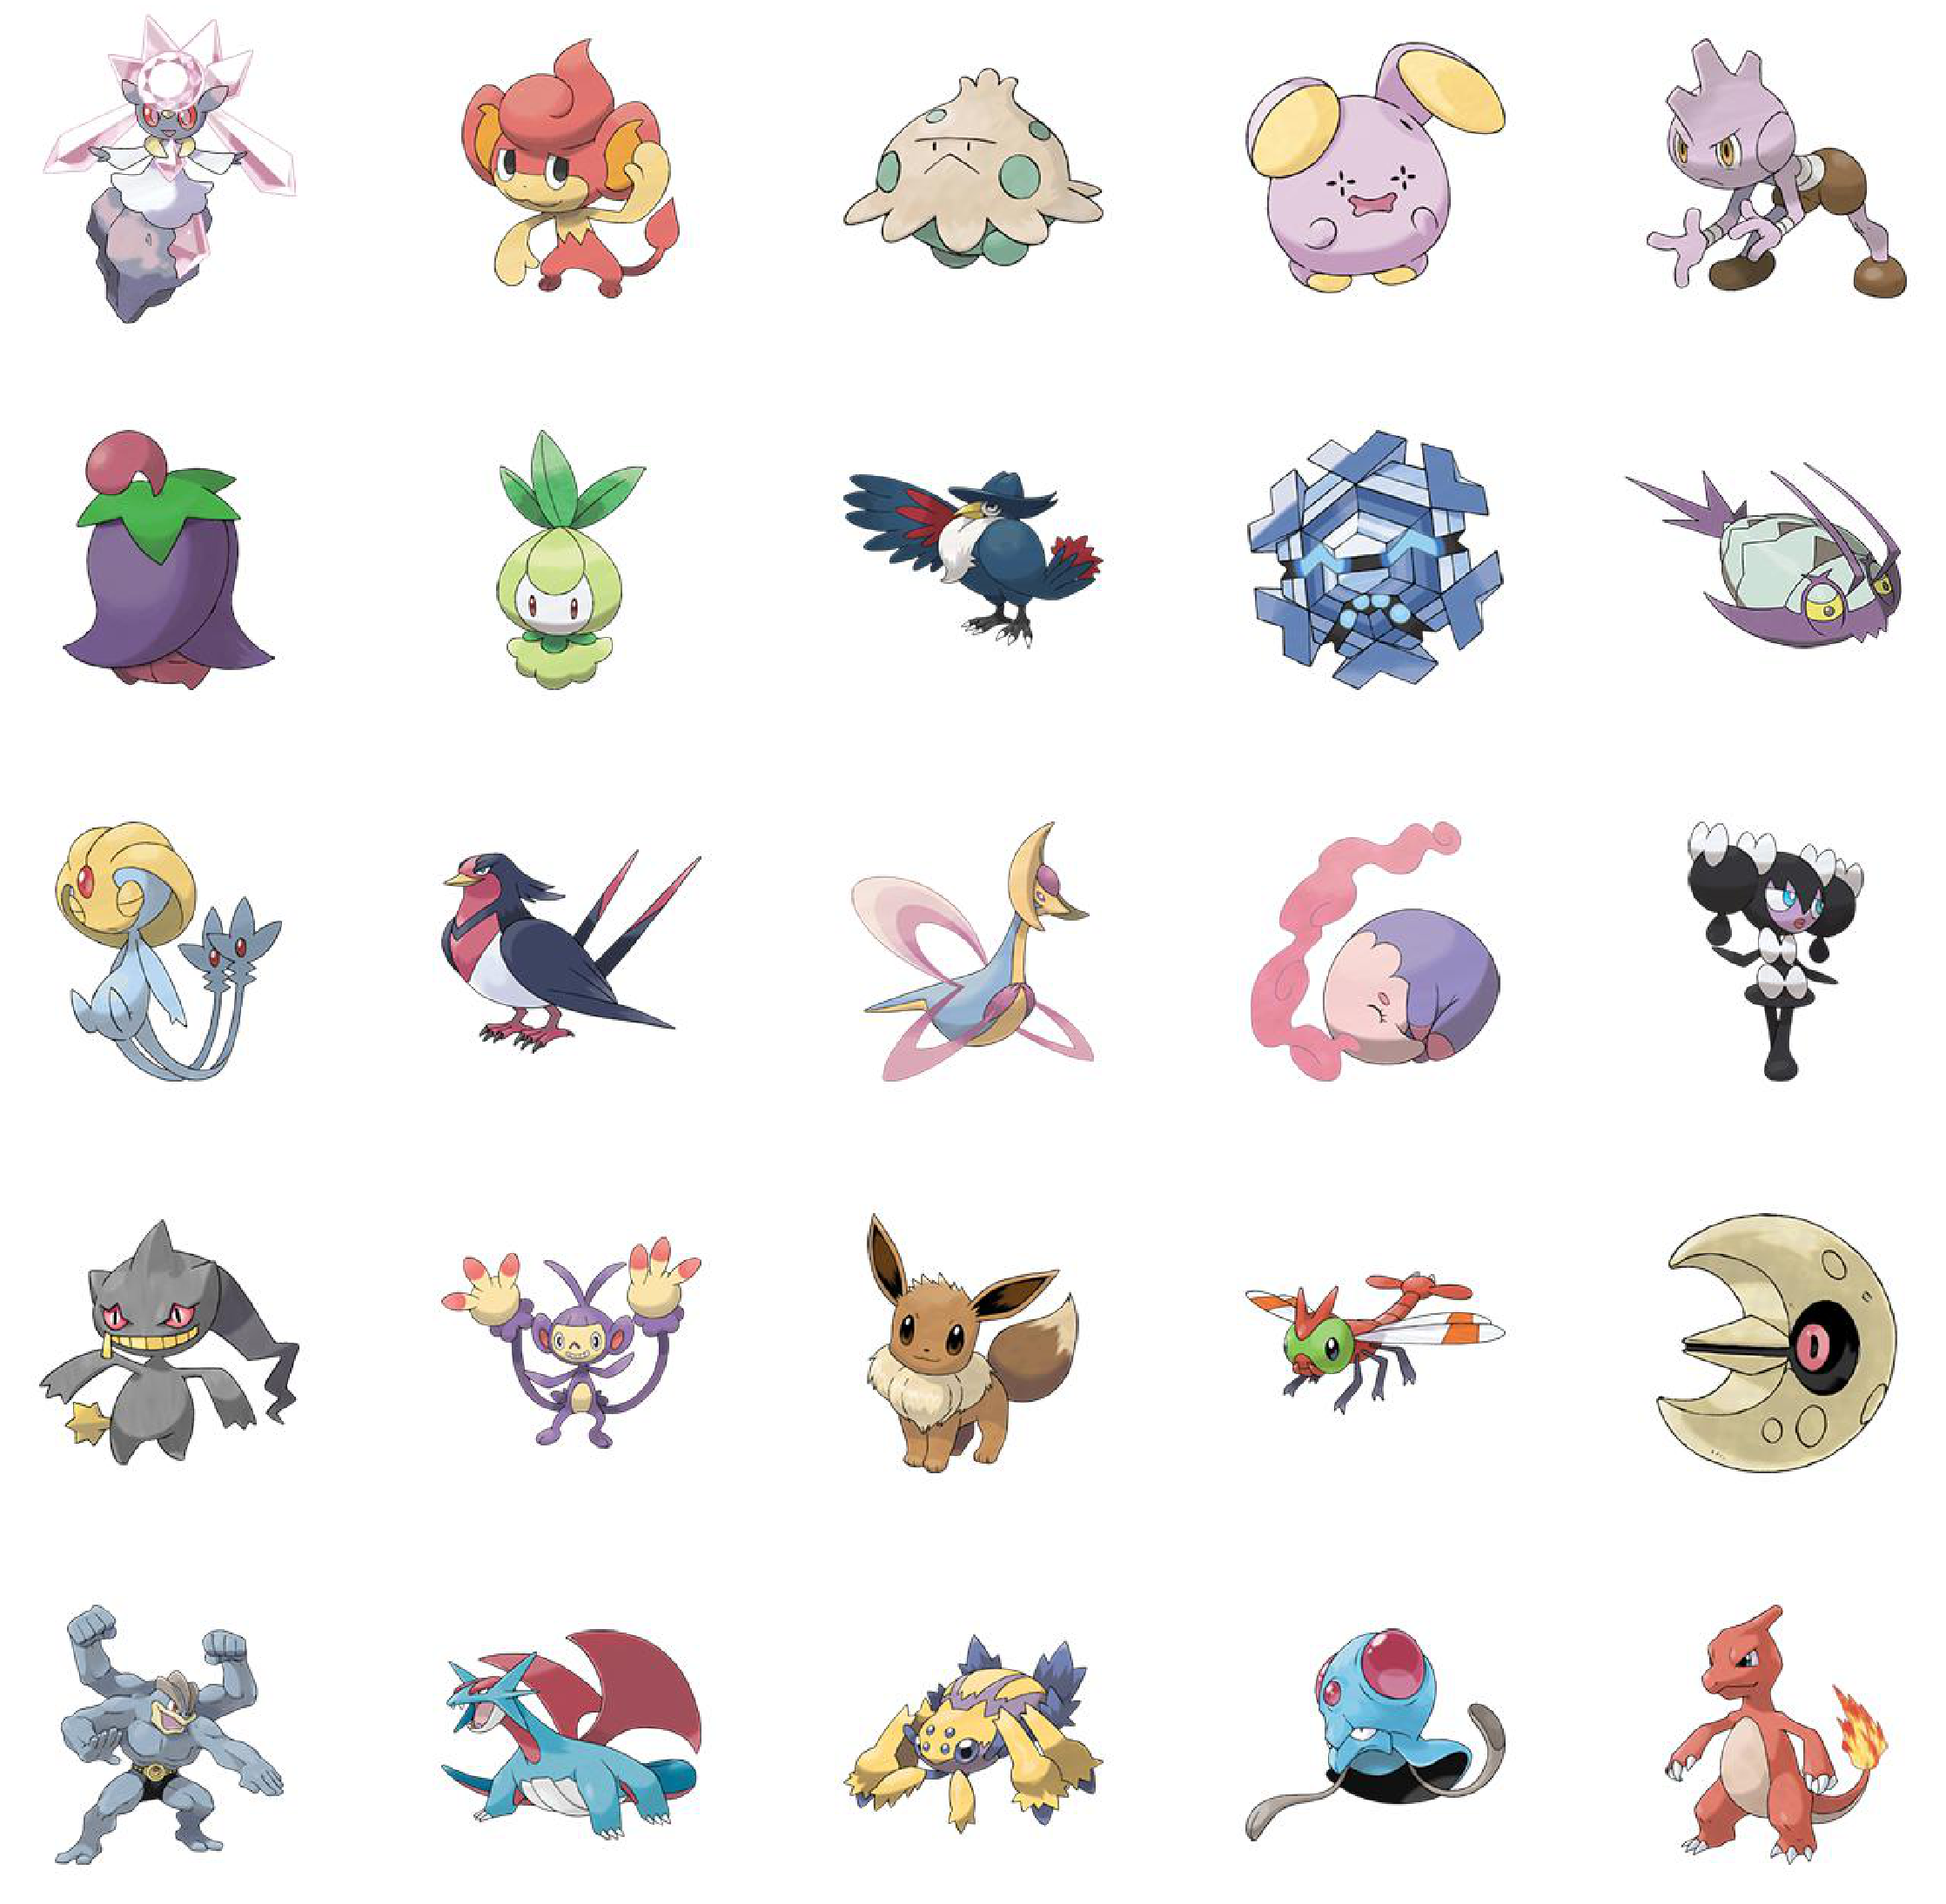

In [10]:
fig = plt.figure(figsize = (40, 40))

for i in range(25):
    rd = np.random.randint(800)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(Image.open(imgs[rd]))
    ax.autoscale(False)
    ax.axis('off')
    
plt.show()

In [34]:
class MyDataset(Dataset):
    def __init__(self, paths, labels, transform, image_size):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index]
        label = self.labels[index]

        if self.transform is not None:
            image = cv2.imread(image_path)
            if type(self.transform) == albumentations.core.composition.Compose:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                tensor = self.transform(image=image)['image']
            else:
                tensor = Image.open(image_path).resize(image_size[1:])
                tensor = self.transform(tensor)
        return tensor

    
transformation = Compose([
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
pk_dataset = MyDataset(imgs, [0 for i in range(len(imgs))], transformation, image_size)
pk_dataloader = DataLoader(pk_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True, drop_last = True)

## Model 

In [37]:
class Generator(nn.Module):
    def __init__(self, in_dim, kernel_size = 5, stride = 2, padding = 2):
        super(Generator, self).__init__()

        self.latent_dim = in_dim
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.layer1 = self.first_layer(self.latent_dim, 512) #2 linear transformation here
        self.layer2 = self.conv_module(256, 128)
        self.layer3 = self.conv_module(128, 64)
        self.layer4 = self.conv_module(64, 32)
        self.layer5 = self.last_layer(32, 3)
        
    def first_layer(self, latent_dim, out_num):
        return nn.Sequential(
            nn.Linear(latent_dim, out_num),
            nn.ReLU(),
            nn.Linear(out_num, int(out_num*8*8/2)),
            nn.ReLU(),
            nn.BatchNorm1d(int(out_num*8*8/2))
        )

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.ConvTranspose2d(in_num, out_num, self.kernel_size, stride = self.stride, padding = self.padding , output_padding = int(self.stride/2)),
            nn.BatchNorm2d(out_num),
            nn.ReLU()
        )

    def last_layer(self, in_num, out_num):
        return nn.Sequential(
            nn.ConvTranspose2d(in_num ,out_num, self.kernel_size, stride = self.stride, padding = self.padding, output_padding = int(self.stride/2)),
            nn.Tanh()
        )

    def forward(self, X):
        out = self.layer1(X)
        out = self.layer2(out.view(-1, 256, 8, 8))
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [38]:
class Discriminator(nn.Module):
    def __init__(self, kernel_size = 5, stride = 2, padding = 2):
        super(Discriminator,self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.layer1 = self.conv_module(3, 32)
        self.layer2 = self.conv_module(32, 64)
        self.layer3 = self.conv_module(64, 128)
        self.layer4 = self.conv_module(128, 256)

        self.fc1 = nn.Linear(256*8*8, 512)
        self.dp = nn.Dropout(0.5)
        self.d_out = nn.Linear(512, 1)
    
    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, self.kernel_size, stride = self.stride, padding = self.padding),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(0.2)
        )

    def forward(self,X):
        out = self.layer1(X)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view((-1, 256*8*8))
        out = self.dp(F.leaky_relu(self.fc1(out)))
        out = self.d_out(out)
        return out

# Loss

In [39]:
def loss_with_penalty(D, rdata, fdata, LAMBDA):
    alpha = torch.rand(rdata.size())
    alpha = alpha.cuda(device) if use_GPU else alpha

    interpolates = alpha * rdata + ((1 - alpha) * fdata)

    interpolates = Variable(interpolates, requires_grad=True)
    if use_GPU:
        interpolates = interpolates.cuda(device)

    disc_interpolates = D(interpolates)
    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).cuda(device) if use_GPU else torch.ones(disc_interpolates.size()),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# Training initialisation

In [40]:
def get_noise(batch_size=batch_size):
    return Variable(torch.rand(batch_size,latent_dim))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [41]:
d_model = Discriminator()
g_model = Generator(latent_dim)

d_model.apply(weights_init)
g_model.apply(weights_init)

d_optimizer = Adam(d_model.parameters(),lr=1e-4,betas=[0.01,.9])
g_optimizer = Adam(g_model.parameters(),lr=1e-4,betas=[0.01,.9])

if use_GPU:
    d_model.cuda(device)
    g_model.cuda(device)

In [15]:
d_iter = 1
g_iter = 1
epoch = 6000

# Train model 

In [42]:
g_loss_list = []
d_loss_list = []
w_distance_list = []

for e in tqdm(range(epoch)):
    for data in pk_dataloader:
        for i in range(d_iter):
            #real data
            for p in d_model.parameters():
                p.requires_grad = True
            d_model.zero_grad()
            true_data = Variable(data)
            if use_GPU:
                true_data=true_data.cuda(device)
            d_true_score = d_model(true_data)
            true_loss = -d_true_score.mean()
            
            #fake data
            noise = get_noise(true_data.size()[0])
            if use_GPU:
                noise = noise.cuda(device)
            fake_data = g_model(noise)
            d_fake_score = d_model(fake_data)
            fake_loss = d_fake_score.mean()
            w_loss = loss_with_penalty(d_model, true_data.data, fake_data.data, LAMBDA)
            loss = true_loss+fake_loss+w_loss
            loss.backward()
            d_optimizer.step()
            
        for i in range(g_iter):
            #train G
            g_model.zero_grad()
            for p in d_model.parameters():
                p.requires_grad = False
            noise = get_noise()
            if use_GPU:
                noise = noise.cuda(device)
            fake_data = g_model(noise)
            g_score = d_model(fake_data)
            g_loss = -g_score.mean()
            g_loss.backward()
            g_optimizer.step()
            
    dloss=float(true_loss) + float(fake_loss) + float(w_loss)
    d_loss_list.append(dloss)
    gloss=float(g_loss)
    g_loss_list.append(gloss)
    w_distance=-float(true_loss)-float(fake_loss)
    w_distance_list.append(w_distance)

    fake_imgs=fake_data.cpu().data*0.5 +0.5
    if e%30==0:
        img = ToPILImage()(fake_imgs[3])
        img.save(os.path.join(res_path, 'G_result/iter_%d.png'%e))
        torch.save(d_model, os.path.join(res_path, 'D_checkpoint/iter_d_%d.pt'%e))
        torch.save(g_model, os.path.join(res_path, 'G_checkpoint/iter_g_%d.pt'%e))

KeyboardInterrupt: 